In [1]:
import numpy as np
import pandas as pd
import os 

In [2]:
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

we split dataset: 70%, 20%, 10%

In [3]:
ann_df = pd.read_csv(
    'annotations.csv'
)
meta_df = pd.read_csv(
    'metadata.csv'
)
ann_df.shape

features_dir = "audio_features"
labels_dir = "labels"

In [4]:
train_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[:int(len(meta_df)*0.7)]
validation_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.7):int(len(meta_df)*0.9)]
test_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.9):len(meta_df)]

train_filename[0]


'277070.mp3'

In [5]:
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

In [6]:
import numpy as np
from sklearn.decomposition import PCA

import numpy as np

def pad_embeddings(embeddings_list, max_len=None, pad_value=0):
    lengths = [emb.shape[0] for emb in embeddings_list]
    max_len = max_len or max(lengths)
    feature_dim = embeddings_list[0].shape[1]
    
    padded = np.full((len(embeddings_list), max_len, feature_dim), pad_value, dtype=embeddings_list[0].dtype)
    
    for i, emb in enumerate(embeddings_list):
        length = emb.shape[0]
        padded[i, :length, :] = emb  # copy original embedding into padded array
    
    return padded, lengths

def pca25(filenames):
    reduced_embeddings = []
    for filename in filenames:
        path = os.path.join(features_dir, filename.split('.')[0] + '.npz')
        embedding = np.load(path)["embeddings"]
        embedding = np.squeeze(embedding)

        
        pca = PCA(25)
        low_dim_emb = pca.fit_transform(embedding) 
        reduced_embeddings.append(low_dim_emb)

    padded_embeddings, original_lengths = pad_embeddings(reduced_embeddings)

    return np.array(padded_embeddings)



In [7]:
reduced_train_em = pca25(train_filename)
reduced_valid_em = pca25(validation_filename)
reduced_test_em = pca25(test_filename)


In [8]:
reduced_train_em.shape

(5761, 250, 25)

In [9]:
import itertools
def read_files(file_names, reduced_em):
    X_train = []
    Y_train = {c: [] for c in categories}  # Initialize label dictionary
    
    for i, (f, em) in enumerate(zip(file_names, reduced_em)):
        # Load melspectrogram and MFCC features
        features_mel = np.load(os.path.join(features_dir, f.split('.')[0] + '.npz'))["melspectrogram"]
        features_mfcc = np.load(os.path.join(features_dir, f.split('.')[0] + '.npz'))["mfcc"]
        
        # Get the embedding for this file (already reduced to 25 dimensions)
        features_em = em  # This is the precomputed PCA-reduced embedding for this file
        
        # Pad or truncate all features to have the same number of timesteps
        min_length = min(features_mel.shape[0], features_mfcc.shape[0], features_em.shape[0])
        features_mel = features_mel[:min_length]
        features_mfcc = features_mfcc[:min_length]
        features_em = features_em[:min_length]
        
        # Concatenate features along feature axis (axis=1)
        features = np.concatenate([features_mel, features_mfcc, features_em], axis=1)
        X_train.append(features)
        
        # Load and process labels
        y = np.load(os.path.join(labels_dir, f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y))[:min_length])  # Match length
    
    X_train = np.concatenate(X_train)
    return X_train, Y_train

In [10]:
from sklearn.preprocessing import StandardScaler
def preprocessing(array):
    s=StandardScaler()
    scaled_array = s.fit_transform(array)
    scalar =s.fit(array)
    return scaled_array,scalar.mean_,scalar.scale_

In [11]:
train_x,train_y_ = read_files(train_filename,reduced_train_em)
val_x, val_y_ = read_files(validation_filename,reduced_valid_em)
test_x, test_y_ = read_files(test_filename,reduced_test_em)

In [12]:
train_x.shape

(1078243, 121)

In [13]:
train_x.shape
val_x.shape
test_x.shape
print(f'shape of train set:{train_x.shape}, shape of val set:{val_x.shape}, shape of test set:{test_x.shape}')
#print(f'shape of train_y set:{train_y.shape}, shape of val_y set:{val_y.shape}, shape of test_y set:{test_y.shape}')

shape of train set:(1078243, 121), shape of val set:(305277, 121), shape of test set:(155057, 121)


In [14]:
scaled_train_x,mu,std =preprocessing(train_x)
scaled_validation_x = (val_x - mu)/std
scaled_test_x = (test_x - mu)/std

**Gradient Boosting lib**

In [15]:
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

#train_y = train_y[categories].to_numpy().astype(np.int32)
#val_y = val_y[categories].to_numpy().astype(np.int32)
#test_y = test_y[categories].to_numpy().astype(np.int32)
#train_y.shape

train_y = np.array([train_y_[cls] for cls in categories]).T
val_y = np.array([val_y_[cls] for cls in categories]).T
test_y = np.array([test_y_[cls] for cls in categories]).T


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
param_grid = {
    'max_depth': [10,15,None],
    'n_estimators': [10,50,100]
}
best_score = 0
best_params = None
best_model = None

In [20]:
for max_depth, n_estimators in itertools.product(
    param_grid['max_depth'],
    param_grid['n_estimators']
):
    print(f"\nTraining with max_depth={max_depth}, n_estimators={n_estimators}")
    
    xgb_gpu = XGBClassifier(
        tree_method='hist',  # enables GPU
        device='cuda',
        objective='binary:logistic',
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=0.1,
        subsample=0.8,
        eval_metric='logloss'
    )
    train_y = (train_y > 0).astype(int)
    val_y = (val_y > 0).astype(int)

    xgb_multi = MultiOutputClassifier(xgb_gpu)
    xgb_multi.fit(scaled_train_x, train_y)

    pred_y = xgb_multi.predict(scaled_validation_x)
    n_labels = val_y.shape[1]
    balanced_accuracies = []

    for i in range(n_labels):
        score = balanced_accuracy_score(val_y[:, i], pred_y[:, i])
        balanced_accuracies.append(score)

    macro_score = np.mean(balanced_accuracies)
    print(f"→ Macro-Averaged Balanced Accuracy: {macro_score:.4f}")

    if macro_score > best_score:
        best_score = macro_score
        best_params = {'max_depth': max_depth, 'n_estimators': n_estimators}
        best_model = xgb_multi

print("\n✅ Best Parameters:")
print(best_params)
print(f"✅ Best Macro-Averaged Balanced Accuracy: {best_score:.4f}")


Training with max_depth=10, n_estimators=10


/home/abdul/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:09:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742531908307/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


→ Macro-Averaged Balanced Accuracy: 0.5166

Training with max_depth=10, n_estimators=50
→ Macro-Averaged Balanced Accuracy: 0.5365

Training with max_depth=10, n_estimators=100
→ Macro-Averaged Balanced Accuracy: 0.5439

Training with max_depth=15, n_estimators=10
→ Macro-Averaged Balanced Accuracy: 0.5195

Training with max_depth=15, n_estimators=50
→ Macro-Averaged Balanced Accuracy: 0.5388

Training with max_depth=15, n_estimators=100
→ Macro-Averaged Balanced Accuracy: 0.5426

Training with max_depth=None, n_estimators=10
→ Macro-Averaged Balanced Accuracy: 0.5116

Training with max_depth=None, n_estimators=50
→ Macro-Averaged Balanced Accuracy: 0.5280

Training with max_depth=None, n_estimators=100
→ Macro-Averaged Balanced Accuracy: 0.5366

✅ Best Parameters:
{'max_depth': 10, 'n_estimators': 100}
✅ Best Macro-Averaged Balanced Accuracy: 0.5439


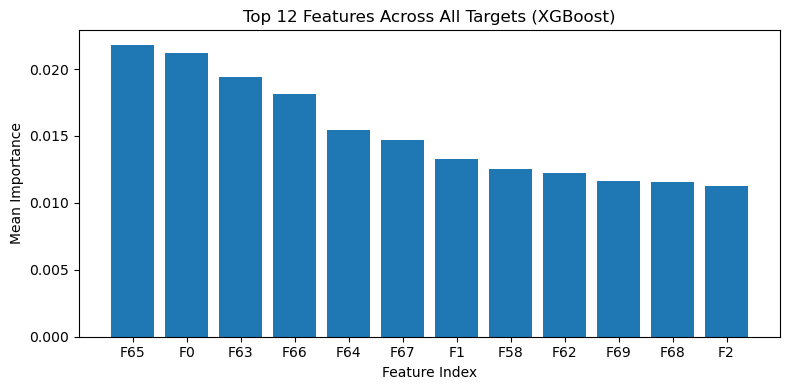

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- Extract feature importances across all label estimators ---
importances = []
for estimator in best_model.estimators_:
    importances.append(estimator.feature_importances_)

# Convert to NumPy array: shape (n_labels, n_features)
importances = np.array(importances)

# --- Mean importance across all labels ---
mean_importance = importances.mean(axis=0)
top_n = 12
top_indices = np.argsort(mean_importance)[-top_n:][::-1]
top_values = mean_importance[top_indices]

# --- Plot ---
plt.figure(figsize=(8, 4))
plt.bar(range(top_n), top_values, tick_label=[f'F{i}' for i in top_indices])
plt.title(f"Top {top_n} Features Across All Targets (XGBoost)")
plt.xlabel("Feature Index")
plt.ylabel("Mean Importance")
plt.tight_layout()
plt.show()
